In [1]:
import sys
sys.path.append("../src") # Adds higher directory to python modules path.

from early_text_classifier import EarlyTextClassifier
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('poster')

import warnings
warnings.filterwarnings('ignore')

In [2]:
etc_kwargs = {'dataset_path': '../dataset/erisk',
              'dataset_name': 'erisk-clean-stemmed',
              'initial_step': 1,
              'step_size': 1}
preprocess_kwargs = {'min_word_length': 2,
                     'max_number_words': None}
cpi_model_params = dict()
cpi_model_params['alpha'] = 0.50
cpi_model_params['fit_prior'] = True
cpi_kwargs = {'train_dataset_percentage': 0.75,
              'test_dataset_percentage': 0.25,
              'doc_rep': 'term_frec',
              'model_type': 'MultinomialNB',
              'cpi_model_params': cpi_model_params}
context_kwargs = {'number_most_common': 100}
dmc_model_params = dict()
dmc_model_params['C'] = 2
dmc_model_params['solver'] = 'liblinear'
dmc_model_params['n_jobs'] = 1
dmc_model_params['random_state'] = 0
dmc_kwargs = {'train_dataset_percentage': 0.75,
              'test_dataset_percentage': 0.25,
              'model_type': 'LogisticRegression',
              'dmc_model_params': dmc_model_params}

etc = EarlyTextClassifier(etc_kwargs, preprocess_kwargs, cpi_kwargs,
                          context_kwargs, dmc_kwargs)

In [3]:
etc.print_params_information()

Dataset name: erisk-clean-stemmed
Dataset path: ../dataset/erisk
--------------------------------------------------------------------------------
Pre-process params:
{'max_number_words': None, 'min_word_length': 2}
--------------------------------------------------------------------------------
CPI params:
{'cpi_model_params': {'alpha': 0.5, 'fit_prior': True},
 'doc_rep': 'term_frec',
 'initial_step': 1,
 'model_type': 'MultinomialNB',
 'step_size': 1,
 'test_dataset_percentage': 0.25,
 'train_dataset_percentage': 0.75}
--------------------------------------------------------------------------------
Context Information params:
{'initial_step': 1, 'number_most_common': 100, 'step_size': 1}
--------------------------------------------------------------------------------
DMC params:
{'dmc_model_params': {'C': 2,
                      'n_jobs': 1,
                      'random_state': 0,
                      'solver': 'liblinear'},
 'model_type': 'LogisticRegression',
 'test_dataset_perc

In [4]:
Xtrain, ytrain, Xtest, ytest = etc.preprocess_dataset()
etc.fit(Xtrain, ytrain)

Pre-processing dataset
Building dictionary
8331236  total words  83805  unique words
Xtrain.shape: (486, 127325)
ytrain.shape: (486,)
Xtest.shape: (401, 156935)
ytest.shape: (401,)
Training EarlyTextClassifier model
Obtaining information from the preprocessed training data
Splitting preprocessed dataset for the PartialInformationClassifier
cpi_Xtrain.shape: (364, 127325)
cpi_ytrain.shape: (364,)
cpi_Xtest.shape: (122, 127325)
cpi_ytest.shape: (122,)
Training PartialInformationClassifier
cpi_Xtrain_representation.shape: (364, 83806)
Predicting with PartialInformationClassifier
cpi_partial[i]_Xtest_representation.shape: (122, 83806)
Generating DecisionClassifier dataset
Splitting preprocessed dataset for the DecisionClassifier
dmc_Xtrain.shape: (100, 92, 12)
dmc_ytrain.shape: (100, 92)
dmc_Xtest.shape: (100, 30, 12)
dmc_ytest.shape: (100, 30)
Training PartialInformationClassifier
Predicting with DecisionClassifier


In [5]:
cpi_perc, cpi_pred, dmc_pred, pred_time, dmc_ytest = etc.predict(Xtest, ytest)

Predicting with the EarlyTextClassifier model
Predicting with PartialInformationClassifier
cpi_partial[i]_Xtest_representation.shape: (401, 83806)
Generating DecisionClassifier dataset
Predicting with DecisionClassifier


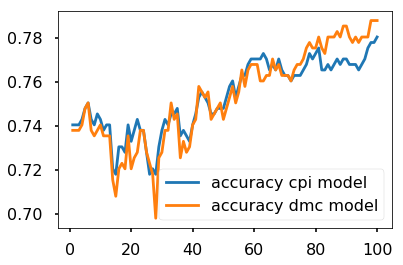

In [6]:
num_steps = len(cpi_perc)
x = cpi_perc
accuracy_cpi = np.sum(cpi_pred == ytest, axis=1) / ytest.size
y_cpi = np.zeros(num_steps)
y_dmc = np.zeros(num_steps)
for idx in range(num_steps):
    y_cpi[idx] = np.sum(cpi_pred[idx] == ytest) / ytest.size
    y_dmc[idx] = np.sum(dmc_pred[idx] == dmc_ytest[idx]) / dmc_ytest[idx].size

plt.plot(x, y_cpi, label='accuracy cpi model')
plt.plot(x, y_dmc, label='accuracy dmc model')
plt.legend();

In [7]:
penalization_type = 'Losada-Crestani'
time_threshold = 50
costs = {'c_tp': 1.0,
         'c_fn': 1.0,
         'c_fp': 'proportion_positive_cases'}

etc.score(ytest, cpi_pred, cpi_perc, pred_time, penalization_type,
          time_threshold, costs);

                    Score ETC                     
--------------------------------------------------
 Precision average=macro: 0.589
    Recall average=macro: 0.655
F1 Measure average=macro: 0.594
                Accuracy: 0.741
              ERDE o=50 : 0.0599
--------------------------------------------------
             precision    recall  f1-score   support

   negative       0.92      0.77      0.84       349
   positive       0.26      0.54      0.35        52

avg / total       0.83      0.74      0.77       401

--------------------------------------------------
Confusion matrix:
array([[269,  80],
       [ 24,  28]])


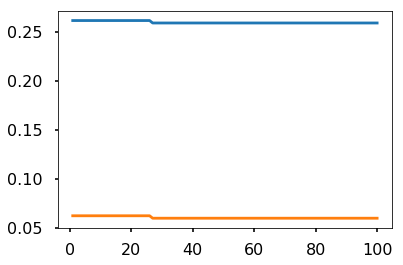

In [8]:
penalization_type = 'Losada-Crestani'
costs_1 = {'c_tp': 1.0,
         'c_fn': 1.0,
         'c_fp': 1.0}
costs_2 = {'c_tp': 1.0,
         'c_fn': 1.0,
         'c_fp': 'proportion_positive_cases'}

time_threshold = np.linspace(start=1, stop=100, num=100)
erde_1 = np.zeros_like(time_threshold)
erde_2 = np.zeros_like(time_threshold)
for idx, o in enumerate(time_threshold):
    erde_1[idx] = etc.score(ytest, cpi_pred, cpi_perc, pred_time, penalization_type, o, costs_1, print_ouput=False)
    erde_2[idx] = etc.score(ytest, cpi_pred, cpi_perc, pred_time, penalization_type, o, costs_2, print_ouput=False)

plt.plot(time_threshold, erde_1)
plt.plot(time_threshold, erde_2);

In [9]:
etc.save_model()

Saving model
